In [1]:
import sys

sys.path.append("../python")

import math
import matplotlib.pyplot as plt
from preprocess_data import EigenfacesDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(315)
plt.rcParams['font.size'] = '16'

In [3]:
NUM_EPOCHS = 10
BATCH_SIZE = 20
LEARNING_RATE = 1e-3
SCALE=1

In [4]:
def train(net, train_loader, test_loader,
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   # Loop over each batch in train_loader

            # If you are using a GPU, speed up computation by moving values to the GPU
            if torch.cuda.is_available():
                net = net.cuda()
                images = images.cuda()
                labels = labels.cuda()
                
            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true 
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes
            
            if batch_num % BATCH_SIZE == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

            batch_num += 1

        if compute_accs:
            train_acc = accuracy(net, train_loader)
            test_acc = accuracy(net, test_loader)

            print(f'Epoch [{epoch}/{num_epochs}], ',
                  f'Train Accuracy {100 * train_acc:.2f}%, ',
                  f'Test Accuracy {100 * test_acc:.2f}%')
            
            train_accs.append(train_acc)
            test_accs.append(test_acc)

    if compute_accs:
        return train_accs, test_accs
    else:
        return None


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        if  torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained.
                   Each dictionary should have the keys:
                        * train_accs: A list of train accuracies
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      label = model_history['label']
      val = plt.plot(epochs, model_history['test_accs'],
                     '--', label=label + ' test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=label + ' train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])

In [5]:
class OneConvolutionNet(nn.Module):
    def __init__(self, num_classes):
        super(OneConvolutionNet, self).__init__()
        kernel_size = 5
        out_channels = 25
        self.conv = nn.Conv2d(
            in_channels=1,
            out_channels=out_channels,
            kernel_size=kernel_size)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2)
        self.linear = nn.LazyLinear(out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

class TwoConvolutionNet(nn.Module):
    def __init__(self, num_classes):
        super(TwoConvolutionNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=20,
            kernel_size=5)
        self.conv2 = nn.Conv2d(
            in_channels=20,
            out_channels=50,
            kernel_size=5)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2)
        self.linear1 = nn.LazyLinear(out_features=25)
        self.linear2 = nn.LazyLinear(out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [6]:
def get_loader(label, data_dir):
    normalize_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(0.5, 0.5)])
    dataset = EigenfacesDataset(
        data_dir=data_dir,
        label=label,
        scale=SCALE,
        transform=normalize_transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    return dataloader

def make_net(label, net_name):
    train_loader = get_loader(label, '../train_data')
    test_loader = get_loader(label, '../test_data')
    num_classes = train_loader.dataset.num_classes
    if net_name == 'OneConvolutionNet':
        net = OneConvolutionNet(num_classes)
    elif net_name == 'TwoConvolutionNet':
        net = TwoConvolutionNet(num_classes)
    return (net, train_loader, test_loader)

def run_models(net_name):
    labels = ['eye_state', 'facial_expression', 'head_position']
    histories = []
    for label in labels:
        net, train_loader, test_loader = make_net(label, net_name)
        train_history, test_history = train(
            net, train_loader, test_loader, 
            num_epochs=NUM_EPOCHS, 
            learning_rate=LEARNING_RATE, 
            compute_accs=True)
        histories.append({
            'label': label,
            'train_accs': train_history,
            'test_accs': test_history
        })

    plot_history(histories)

/Users/apple/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10],  Train Accuracy 68.28%,  Test Accuracy 60.50%
Epoch [2/10],  Train Accuracy 60.75%,  Test Accuracy 49.77%
Epoch [3/10],  Train Accuracy 79.03%,  Test Accuracy 58.68%
Epoch [4/10],  Train Accuracy 87.63%,  Test Accuracy 61.64%
Epoch [5/10],  Train Accuracy 93.01%,  Test Accuracy 63.47%
Epoch [6/10],  Train Accuracy 97.85%,  Test Accuracy 60.50%
Epoch [7/10],  Train Accuracy 98.39%,  Test Accuracy 61.87%
Epoch [8/10],  Train Accuracy 99.46%,  Test Accuracy 62.10%
Epoch [9/10],  Train Accuracy 98.92%,  Test Accuracy 65.53%
Epoch [10/10],  Train Accuracy 99.46%,  Test Accuracy 64.61%
Epoch [1/10],  Train Accuracy 28.49%,  Test Accuracy 26.48%
Epoch [2/10],  Train Accuracy 27.42%,  Test Accuracy 25.34%
Epoch [3/10],  Train Accuracy 33.33%,  Test Accuracy 29.45%
Epoch [4/10],  Train Accuracy 38.17%,  Test Accuracy 25.11%
Epoch [5/10],  Train Accuracy 45.70%,  Test Accuracy 27.40%
Epoch [6/10],  Train Accuracy 43.55%,  Test Accuracy 26.48%
Epoch [7/10],  Train Accuracy 50.54%,  

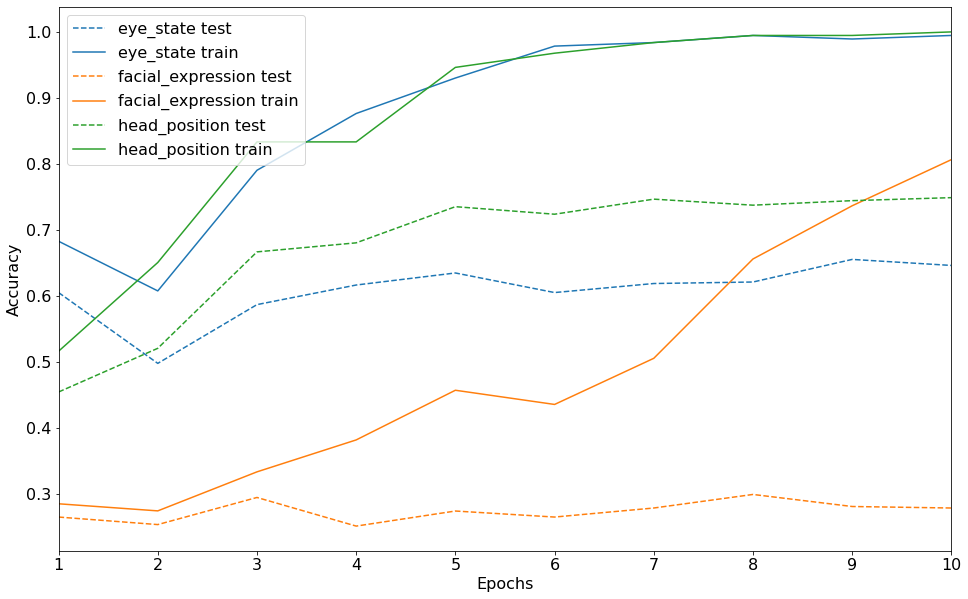

In [7]:
run_models('OneConvolutionNet')

Epoch [1/10],  Train Accuracy 75.27%,  Test Accuracy 64.38%
Epoch [2/10],  Train Accuracy 80.11%,  Test Accuracy 63.01%
Epoch [3/10],  Train Accuracy 61.83%,  Test Accuracy 59.82%
Epoch [4/10],  Train Accuracy 82.80%,  Test Accuracy 68.72%
Epoch [5/10],  Train Accuracy 80.11%,  Test Accuracy 71.23%
Epoch [6/10],  Train Accuracy 93.55%,  Test Accuracy 69.63%
Epoch [7/10],  Train Accuracy 76.88%,  Test Accuracy 67.58%
Epoch [8/10],  Train Accuracy 92.47%,  Test Accuracy 67.12%
Epoch [9/10],  Train Accuracy 95.70%,  Test Accuracy 67.12%
Epoch [10/10],  Train Accuracy 97.85%,  Test Accuracy 71.69%
Epoch [1/10],  Train Accuracy 24.19%,  Test Accuracy 25.11%
Epoch [2/10],  Train Accuracy 24.19%,  Test Accuracy 25.11%
Epoch [3/10],  Train Accuracy 24.19%,  Test Accuracy 25.11%
Epoch [4/10],  Train Accuracy 24.73%,  Test Accuracy 25.57%
Epoch [5/10],  Train Accuracy 32.26%,  Test Accuracy 25.57%
Epoch [6/10],  Train Accuracy 40.86%,  Test Accuracy 27.85%
Epoch [7/10],  Train Accuracy 38.17%,  

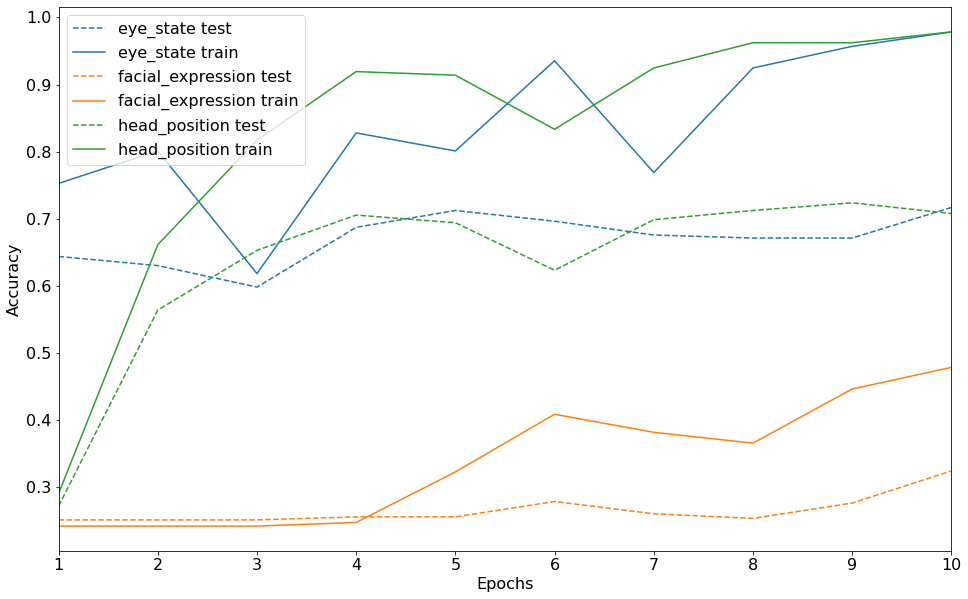

In [8]:
run_models('TwoConvolutionNet')